In [1]:
import numpy as np
import pandas as pd

def simulate_subject_belief(eta, beta, T=60, q0=0.5, Q_keep=10.0, seed=None):
    rng = np.random.default_rng(seed)
    # trustee cooperation schedule: 1-20 0.8, 21-40 0.5, 41-60 0.8
    coop_probs = np.concatenate([np.full(20, 0.8), np.full(20, 0.5), np.full(20, 0.8)])
    trustee_shared = rng.binomial(1, coop_probs)  # s_t
    q = q0
    q_trace = []
    ev_send_trace = []
    p_send_trace = []
    choices = []
    
    for t in range(T):
        # expected value based on current belief
        ev_send = q * 30.0
        # softmax
        exp_send = np.exp(beta * ev_send)
        exp_keep = np.exp(beta * Q_keep)
        p_send = exp_send / (exp_send + exp_keep)
        choice = rng.binomial(1, p_send)
        
        # record
        q_trace.append(q)
        ev_send_trace.append(ev_send)
        p_send_trace.append(p_send)
        choices.append(choice)
        
        # belief update using observed trustee behavior at this trial
        s_t = trustee_shared[t]
        q = q + eta * (s_t - q)
    
    df = pd.DataFrame({
        "trial": np.arange(1, T+1),
        "trustee_shared": trustee_shared,
        "belief_q": q_trace,
        "EV_send": ev_send_trace,
        "p_send": p_send_trace,
        "choice_send": choices,
        "eta": eta,
        "beta": beta
    })
    return df


In [49]:
import numpy as np
import pandas as pd
from scipy.special import expit  # sigmoid

def simulate_subject_belief(
    eta,
    beta,
    T=60,
    q0=0.5,
    value_scale=10.0,
    coop_schedule=None,
    seed=None,
    return_full_trace=True,
):
    """
    Simulate one subject under the model:
      p_send_t = sigmoid( beta * ((q_{t-1} * 30 - 10)/value_scale) )
      q_t = q_{t-1} + eta * (s_t - q_{t-1})
    where s_t is trustee_shared sampled from a piecewise cooperation schedule.

    Parameters
    ----------
    eta : float in (0,1)
    beta : positive float
    T : int, number of trials
    q0 : initial belief
    value_scale : denominator to scale (30 q - 10)
    coop_schedule : array-like of length T giving P(s_t=1); if None uses [0.8]*20 + [0.5]*20 + [0.8]*20
    seed : int or None
    return_full_trace : if True returns DataFrame, else tuple of arrays

    Returns
    -------
    pandas.DataFrame with columns:
        trial, trustee_shared (s_t), belief_q, scaled_diff, delta, p_send, choice_send, eta, beta
    """
    rng = np.random.default_rng(seed)
    if coop_schedule is None:
        coop_schedule = np.concatenate([np.full(20, 0.8), np.full(20, 0.5), np.full(20, 0.8)])
        if len(coop_schedule) != T:
            # adjust if T differs
            coop_schedule = np.interp(
                np.linspace(0, len(coop_schedule)-1, T),
                np.arange(len(coop_schedule)),
                coop_schedule,
            )
    coop_schedule = np.asarray(coop_schedule)  # probabilities

    trustee_shared = rng.binomial(1, coop_schedule, size=T)  # s_t sequence
    q = q0
    q_trace = []
    scaled_diff_trace = []
    delta_trace = []
    p_send_trace = []
    choices = []

    for t in range(T):
        q_trace.append(q)
        scaled_diff = (q * 30.0 - 10.0) / value_scale
        delta = beta * scaled_diff
        p_send = expit(delta)  # sigmoid
        choice = rng.binomial(1, p_send)

        scaled_diff_trace.append(scaled_diff)
        delta_trace.append(delta)
        p_send_trace.append(p_send)
        choices.append(choice)

        # update belief with observed trustee_shared at this trial
        s_t = trustee_shared[t]
        q = q + eta * (s_t - q)

    df = pd.DataFrame({
        "trial": np.arange(1, T+1),
        "trustee_shared": trustee_shared,
        "belief_q": q_trace,
        "scaled_diff": scaled_diff_trace,
        "delta": delta_trace,
        "p_send": p_send_trace,
        "choice_send": choices,
        "eta": eta,
        "beta": beta,
    })
    return df if return_full_trace else (
        np.array(trustee_shared),
        np.array(q_trace),
        np.array(p_send_trace),
        np.array(choices),
    )


def simulate_group(
    n_subjects,
    T=60,
    q0=0.5,
    value_scale=10.0,
    hyperparams=None,
    seed=None,
):
    """
    Simulate a group of subjects with partial-pooling-style priors:
      logit_eta_i ~ Normal(mu_logit_eta, sigma_logit_eta)
      eta_i = sigmoid(logit_eta_i)
      log_beta_i ~ Normal(mu_log_beta, sigma_log_beta)
      beta_i = exp(log_beta_i)

    Each subject uses the same trustee schedule (can be customized inside).

    Parameters
    ----------
    n_subjects : int
    T : int
    q0 : float
    value_scale : float
    hyperparams : dict or None. Defaults to {
        "mu_logit_eta": 0.0, "sigma_logit_eta": 1.0,
        "mu_log_beta": -0.5, "sigma_log_beta": 1.0
    }
    seed : int or None

    Returns
    -------
    pandas.DataFrame with subject-level and trial-level columns:
      subject, trial, trustee_shared, belief_q, scaled_diff, delta, p_send, choice_send,
      eta, beta, logit_eta, log_beta
    """
    rng = np.random.default_rng(seed)
    if hyperparams is None:
        hyperparams = {
            "mu_logit_eta": 0.0,
            "sigma_logit_eta": 1.0,
            "mu_log_beta": -0.5,
            "sigma_log_beta": 1.0,
        }

    mu_logit_eta = hyperparams["mu_logit_eta"]
    sigma_logit_eta = hyperparams["sigma_logit_eta"]
    mu_log_beta = hyperparams["mu_log_beta"]
    sigma_log_beta = hyperparams["sigma_log_beta"]

    records = []
    # shared schedule; could also vary per subject if desired
    coop_schedule = np.concatenate([np.full(20, 0.8), np.full(20, 0.5), np.full(20, 0.8)])
    if len(coop_schedule) != T:
        coop_schedule = np.interp(
            np.linspace(0, len(coop_schedule) - 1, T),
            np.arange(len(coop_schedule)),
            coop_schedule,
        )

    for subj in range(n_subjects):
        # draw subject-level parameters (non-centered style equivalent)
        logit_eta_i = rng.normal(mu_logit_eta, sigma_logit_eta)
        eta_i = expit(logit_eta_i)
        log_beta_i = rng.normal(mu_log_beta, sigma_log_beta)
        beta_i = np.exp(log_beta_i)

        df_sub = simulate_subject_belief(
            eta=eta_i,
            beta=beta_i,
            T=T,
            q0=q0,
            value_scale=value_scale,
            coop_schedule=coop_schedule,
            seed=rng.integers(1 << 30),
            return_full_trace=True,
        )
        df_sub["subject"] = subj
        df_sub["logit_eta"] = logit_eta_i
        df_sub["log_beta"] = log_beta_i
        records.append(df_sub)

    df_group = pd.concat(records, ignore_index=True)
    # reorder columns for clarity
    cols = [
        "subject",
        "trial",
        "trustee_shared",
        "belief_q",
        "scaled_diff",
        "delta",
        "p_send",
        "choice_send",
        "eta",
        "beta",
        "logit_eta",
        "log_beta",
    ]
    return df_group[cols]


In [12]:
import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as at
from pytensor.scan import scan

# consistent float handling
pytensor.config.floatX = "float64"

def build_belief_model(choices, trustee_shared, q0=0.5, value_scale=10.0):
    choices_provided = choices is not None
    if choices_provided:
        choices = np.asarray(choices).astype("int8")
    trustee_shared = np.asarray(trustee_shared, dtype="float64")
    q0 = np.float64(q0)
    value_scale = np.float64(value_scale)

    with pm.Model() as model:
        
        logit_eta = pm.Normal("logit_eta", 0.0, 1.0)
        eta = pm.Deterministic("eta", pm.math.sigmoid(logit_eta))

        log_beta = pm.Normal("log_beta", mu=-1.0, sigma=0.5)
        beta = pm.Deterministic("beta", pm.math.exp(log_beta))

        s_seq = at.as_tensor_variable(trustee_shared)
        q0_tensor = at.as_tensor_variable(q0)

        def step(s_t, q_prev, eta, beta):
            scaled_diff = (q_prev * 30.0 - 10.0) / value_scale
            delta = beta * scaled_diff
            p_send_t = pm.math.sigmoid(delta)
            q_new = q_prev + eta * (s_t - q_prev)
            return q_new, p_send_t

        (q_seq, p_send), _ = scan(
            fn=step,
            sequences=s_seq,
            outputs_info=[q0_tensor, None],
            non_sequences=[eta, beta],
        )

        pm.Deterministic("belief_q", q_seq)
        pm.Deterministic("p_send", p_send)

        if choices_provided:
            pm.Bernoulli("obs", p=p_send, observed=choices)
        else:
            pm.Bernoulli("y", p=p_send)  # prior predictive latent choice

    return model


In [43]:
# create a standard trustee‐sharing schedule
T         = 60
coop_probs = np.concatenate([np.full(20,0.8), np.full(20,0.5), np.full(20,0.8)])
trustee_shared = np.random.default_rng(123).binomial(1, coop_probs, size=T)

# build and sample prior predictive
with build_belief_model(None,trustee_shared) as prior_model:
    prior_pred = pm.sample_prior_predictive(
        samples=300, 
        var_names=["eta", "beta", "belief_q", "p_send", "y"]
    )


Sampling: [log_beta, logit_eta, y]


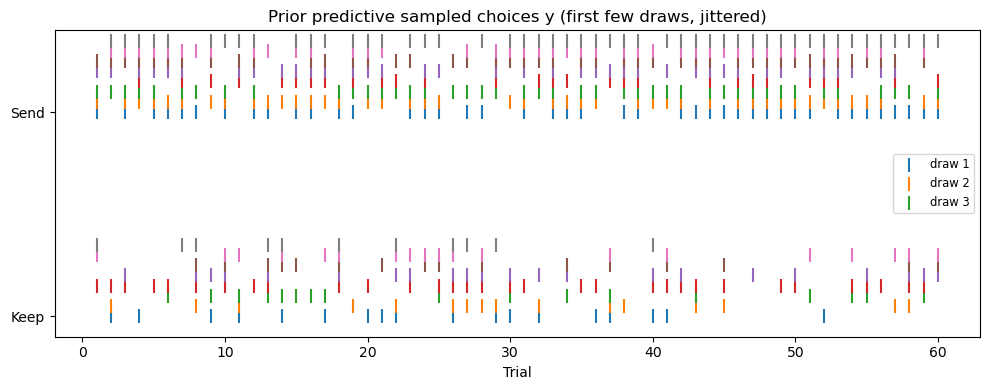

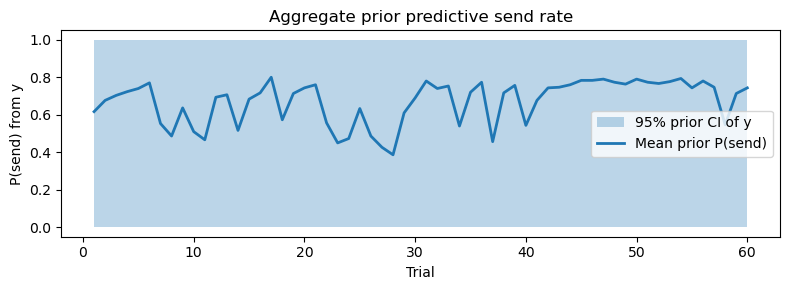

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def extract_y(prior_pred):
    # handles both dict and InferenceData
    if isinstance(prior_pred, dict):
        if "y" in prior_pred:
            y = prior_pred["y"]
        else:
            raise KeyError("`y` not in prior_pred dict; did you use the prior model without observed data?")
    else:
        # InferenceData case: look into prior_predictive or fallback groups
        if hasattr(prior_pred, "prior_predictive") and "y" in prior_pred.prior_predictive.data_vars:
            y = prior_pred.prior_predictive["y"].values
        else:
            # try any group
            found = False
            for group in getattr(prior_pred, "_groups_all", []):
                grp = getattr(prior_pred, group)
                if "y" in getattr(grp, "data_vars", {}):
                    y = grp["y"].values
                    found = True
                    break
            if not found:
                raise KeyError("Could not find 'y' in prior_pred InferenceData. Available vars: "
                               f"{ {g: list(getattr(getattr(prior_pred, g), 'data_vars', [])) for g in prior_pred._groups_all} }")
    # collapse to (n_draws, T) in case of extra chain/draw dims
    if hasattr(y, "shape"):
        y = np.asarray(y)
        y_flat = y.reshape(-1, y.shape[-1])
    else:
        y_flat = np.array(y)[None, :]
    return y_flat  # shape (n_draws, T)

# === usage ===
y_samples = extract_y(prior_pred)  # shape (n_draws, T)
n_draws, T = y_samples.shape
trials = np.arange(1, T+1)

# Raster of a few draws (jittered)
plt.figure(figsize=(10, 4))
n_plot = min(8, n_draws)
for i in range(n_plot):
    plt.scatter(trials, y_samples[i] + i * 0.05, marker='|', s=100,
                label=f"draw {i+1}" if i < 3 else None)
plt.yticks([0, 1], ["Keep", "Send"])
plt.ylim(-0.1, 1 + n_plot * 0.05)
plt.xlabel("Trial")
plt.title("Prior predictive sampled choices y (first few draws, jittered)")
plt.legend(fontsize="small")
plt.tight_layout()
plt.show()

# Aggregate send rate with 95% interval
mean_y = y_samples.mean(axis=0)
lower = np.percentile(y_samples, 2.5, axis=0)
upper = np.percentile(y_samples, 97.5, axis=0)

plt.figure(figsize=(8, 3))
plt.fill_between(trials, lower, upper, alpha=0.3, label="95% prior CI of y")
plt.plot(trials, mean_y, lw=2, label="Mean prior P(send)")
plt.xlabel("Trial")
plt.ylabel("P(send) from y")
plt.title("Aggregate prior predictive send rate")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Single subject with fixed parameters
df = simulate_subject_belief(eta=0.5, beta=1.0, T=60, value_scale=10.0, seed=123)
print(df.head())
choices = df.choice_send.values
trustee_shared = df.trustee_shared.values
print(choices)
print(trustee_shared)

   trial  trustee_shared  belief_q  scaled_diff    delta    p_send  \
0      1               1   0.50000      0.50000  0.50000  0.622459   
1      2               1   0.75000      1.25000  1.25000  0.777300   
2      3               1   0.87500      1.62500  1.62500  0.835484   
3      4               1   0.93750      1.81250  1.81250  0.859664   
4      5               1   0.96875      1.90625  1.90625  0.870597   

   choice_send  eta  beta  
0            1  0.5   1.0  
1            1  0.5   1.0  
2            1  0.5   1.0  
3            1  0.5   1.0  
4            1  0.5   1.0  
[1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0]


In [59]:
with build_belief_model(choices, trustee_shared, value_scale=10.0) as model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.99,   # higher to reduce divergences
        max_treedepth=15,
        return_inferencedata=True
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logit_eta, log_beta]


c:\Users\kaank\miniconda3\envs\pymc_blas\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.


In [60]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

# 1. Basic posterior summary for key parameters
summary = az.summary(
    trace,
    var_names=["eta", "beta", "log_beta", "logit_eta"],
    round_to=2,
    kind="stats"
)
print("Posterior summary:\n", summary)

Posterior summary:
            mean    sd  hdi_3%  hdi_97%
eta        0.53  0.15    0.28     0.83
beta       1.02  0.28    0.51     1.54
log_beta  -0.02  0.28   -0.54     0.51
logit_eta  0.16  0.66   -1.12     1.37


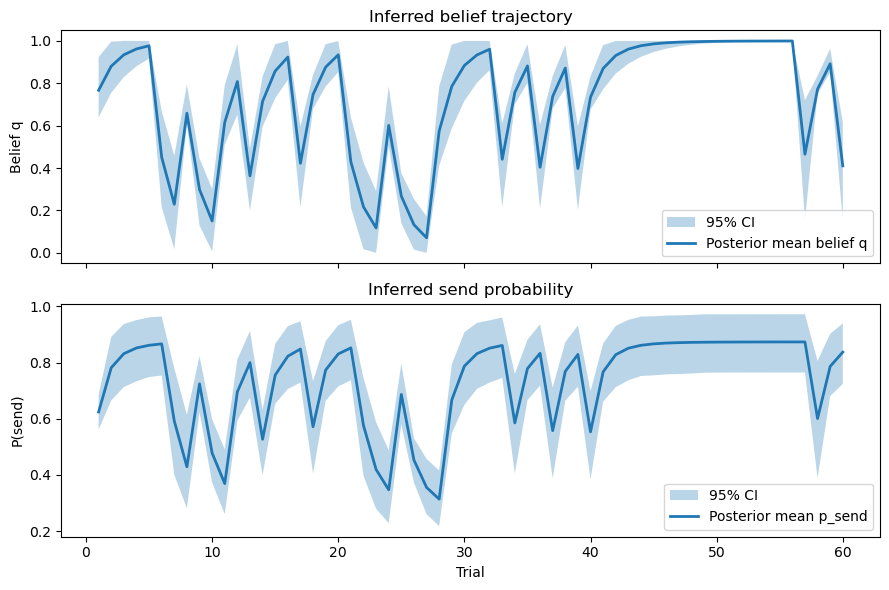

In [61]:
belief_mean = trace.posterior["belief_q"].mean(dim=("chain", "draw")).values.squeeze()
p_send_mean = trace.posterior["p_send"].mean(dim=("chain", "draw")).values.squeeze()
belief_hdi = az.hdi(trace.posterior["belief_q"], hdi_prob=0.95)
p_send_hdi = az.hdi(trace.posterior["p_send"], hdi_prob=0.95)

T = belief_mean.shape[-1]
trials = np.arange(1, T + 1)

fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
# belief q
axs[0].fill_between(
    trials,
    belief_hdi["belief_q"].sel(hdi="lower").values,
    belief_hdi["belief_q"].sel(hdi="higher").values,
    alpha=0.3,
    label="95% CI"
)
axs[0].plot(trials, belief_mean, label="Posterior mean belief q", lw=2)
axs[0].set_ylabel("Belief q")
axs[0].set_title("Inferred belief trajectory")
axs[0].legend()

# p_send
axs[1].fill_between(
    trials,
    p_send_hdi["p_send"].sel(hdi="lower").values,
    p_send_hdi["p_send"].sel(hdi="higher").values,
    alpha=0.3,
    label="95% CI"
)
axs[1].plot(trials, p_send_mean, label="Posterior mean p_send", lw=2)
axs[1].set_ylabel("P(send)")
axs[1].set_xlabel("Trial")
axs[1].set_title("Inferred send probability")
axs[1].legend()

plt.tight_layout()
plt.show()

In [62]:
# 1. Sample posterior predictive; this returns an InferenceData when return_inferencedata=True
with model:  # the same model context you used to sample `trace`
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=["obs", "p_send"],
        random_seed=0,
        return_inferencedata=True,
    )


Sampling: [obs]


c:\Users\kaank\miniconda3\envs\pymc_blas\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

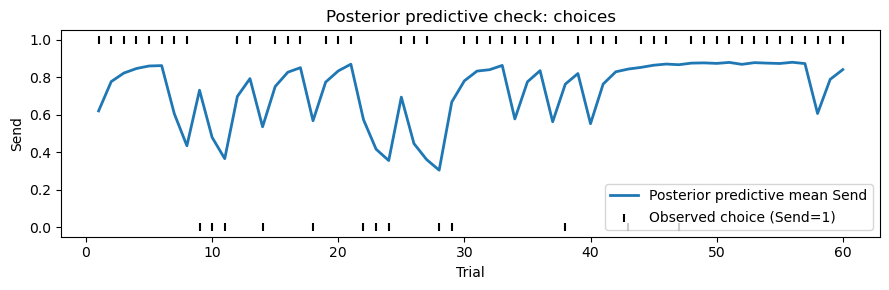

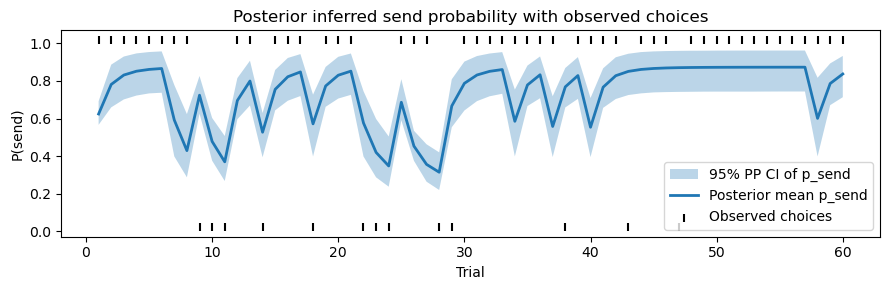

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# extract obs draws robustly
def get_ppc_var(ppc, name):
    # handle dict fallback
    if isinstance(ppc, dict):
        return ppc[name]
    # InferenceData case
    if hasattr(ppc, "posterior_predictive") and name in ppc.posterior_predictive.data_vars:
        arr = ppc.posterior_predictive[name].values
        return arr
    raise KeyError(f"{name} not found in posterior predictive output. Available: {ppc.posterior_predictive.data_vars if hasattr(ppc, 'posterior_predictive') else 'none'}")

ppc_obs = get_ppc_var(ppc, "obs")  # could be shape (chain, draw, T) or (draws, T)
ppc_p_send = get_ppc_var(ppc, "p_send")

# collapse chain/draw axes to (n_samples, T)
def flatten_samples(x):
    if x.ndim == 1:
        return x[None, :]  # unlikely
    return x.reshape(-1, x.shape[-1])

ppc_obs_flat = flatten_samples(ppc_obs)
ppc_p_send_flat = flatten_samples(ppc_p_send)

# posterior predictive mean send choice
mean_ppc_choice = ppc_obs_flat.mean(axis=0)  # length T
mean_p_send = ppc_p_send_flat.mean(axis=0)   # length T
T = mean_ppc_choice.shape[0]
trials = np.arange(1, T+1)

# Plot predictive vs observed (assuming `choices` is your true data)
plt.figure(figsize=(9,3))
plt.plot(trials, mean_ppc_choice, label="Posterior predictive mean Send", lw=2)
plt.scatter(trials, choices, marker="|", color="k", label="Observed choice (Send=1)")
plt.xlabel("Trial")
plt.ylabel("Send")
plt.title("Posterior predictive check: choices") 
plt.legend()
plt.tight_layout()
plt.show()

# Optional: show uncertainty band for p_send
lower = np.percentile(ppc_p_send_flat, 2.5, axis=0)
upper = np.percentile(ppc_p_send_flat, 97.5, axis=0)
plt.figure(figsize=(9,3))
plt.fill_between(trials, lower, upper, alpha=0.3, label="95% PP CI of p_send")
plt.plot(trials, mean_p_send, label="Posterior mean p_send", lw=2)
plt.scatter(trials, choices + 0.02, marker="|", color="k", label="Observed choices", zorder=3)
plt.xlabel("Trial")
plt.ylabel("P(send)")
plt.title("Posterior inferred send probability with observed choices")
plt.legend()
plt.tight_layout()
plt.show()


Hierararhical Model with Subject Groups


In [64]:
import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as at
from pytensor.scan import scan

# make sure consistent float type
pytensor.config.floatX = "float64"

def build_hierarchical_belief_model(choices, trustee_shared, q0=0.5, value_scale=10.0):
    """
    Hierarchical group model.
    choices: array of shape (n_subjects, n_trials), binary 0/1 observed send decisions
    trustee_shared: array of same shape (n_subjects, n_trials), binary feedback
    q0: initial belief
    value_scale: scaling denominator to keep logits moderate
    """
    choices = np.asarray(choices, dtype="int8")  # (S, T)
    trustee_shared = np.asarray(trustee_shared, dtype="float64")  # (S, T)
    S, T = choices.shape
    q0 = float(q0)
    value_scale = float(value_scale)

    with pm.Model() as model:
        # Group-level (hyper) priors: non-centered for eta
        mu_logit_eta = pm.Normal("mu_logit_eta", 0.0, 1.0)
        sigma_logit_eta = pm.HalfNormal("sigma_logit_eta", 1.0)

        mu_log_beta = pm.Normal("mu_log_beta", -0.5, 1.0)
        sigma_log_beta = pm.HalfNormal("sigma_log_beta", 1.0)

        # Subject-level non-centered draws
        z_eta = pm.Normal("z_eta", 0.0, 1.0, shape=S)
        logit_eta = pm.Deterministic("logit_eta", mu_logit_eta + sigma_logit_eta * z_eta)
        eta = pm.Deterministic("eta", pm.math.sigmoid(logit_eta))  # (S,)

        z_log_beta = pm.Normal("z_log_beta", 0.0, 1.0, shape=S)
        log_beta = pm.Deterministic("log_beta", mu_log_beta + sigma_log_beta * z_log_beta)
        beta = pm.Deterministic("beta", pm.math.exp(log_beta))     # (S,)

        # Containers for collecting per-subject sequences
        belief_q_list = []
        p_send_list = []

        for i in range(S):
            s_seq = at.as_tensor_variable(trustee_shared[i])  # (T,)
            q0_tensor = at.as_tensor_variable(np.float64(q0))

            def step(s_t, q_prev, eta_i, beta_i):
                scaled_diff = (q_prev * 30.0 - 10.0) / value_scale
                delta = beta_i * scaled_diff
                p_send_t = pm.math.sigmoid(delta)
                q_new = q_prev + eta_i * (s_t - q_prev)
                return q_new, p_send_t

            (q_seq_i, p_send_i), _ = scan(
                fn=step,
                sequences=s_seq,
                outputs_info=[q0_tensor, None],
                non_sequences=[eta[i], beta[i]],
            )

            belief_q_list.append(q_seq_i)   # shape (T,)
            p_send_list.append(p_send_i)

        # Stack into (S, T)
        belief_q = at.stack(belief_q_list)
        p_send = at.stack(p_send_list)

        pm.Deterministic("belief_q", belief_q)
        pm.Deterministic("p_send", p_send)

        # Observation model: per-subject, per-trial
        pm.Bernoulli("obs", p=p_send, observed=choices)  # shape (S, T)

    return model


In [65]:
# Group of 10 synthetic subjects with hierarchical draws
df_group = simulate_group(n_subjects=10, T=60, value_scale=10.0, seed=42)
print(df_group.groupby("subject").first()[["eta", "beta", "logit_eta", "log_beta"]])

              eta      beta  logit_eta  log_beta
subject                                         
0        0.575595  0.214385   0.304717 -1.539984
1        0.719214  0.086204   0.940565 -2.451035
2        0.213798  0.689244  -1.302180 -0.372160
3        0.495800  0.258452  -0.016801 -1.353044
4        0.706697  1.320211   0.879398  0.277792
5        0.755329  0.968031   1.127241 -0.032491
6        0.297487  0.876999  -0.859292 -0.131249
7        0.706501  0.576993   0.878450 -0.549926
8        0.453916  0.306993  -0.184862 -1.180930
9        0.461444  0.395214  -0.154529 -0.928328


In [66]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# === 1. Simulate synthetic group data ===
# adjust n_subjects / T as desired
n_subjects = 12
T = 60
value_scale = 10.0
seed = 123

# assume simulate_group is defined as in previous message
df_group = simulate_group(
    n_subjects=n_subjects,
    T=T,
    value_scale=value_scale,
    seed=seed
)

# === 2. Prepare arrays for the hierarchical model ===
# shape (subjects, trials)
choices = (
    df_group.pivot(index="subject", columns="trial", values="choice_send")
    .sort_index(axis=0)
    .values
).astype(int)  # (S, T)

trustee_shared = (
    df_group.pivot(index="subject", columns="trial", values="trustee_shared")
    .sort_index(axis=0)
    .values
).astype(float)  # (S, T)

# True generative parameters per subject
true_params = (
    df_group.groupby("subject")
    .first()[["eta", "beta", "logit_eta", "log_beta"]]
    .reset_index()
)  # DataFrame with subject, eta, beta, etc.

# === 3. Fit hierarchical model ===
# assumes build_hierarchical_belief_model(...) is defined
with build_hierarchical_belief_model(choices, trustee_shared, q0=0.5, value_scale=value_scale) as hier_model:
    trace = pm.sample(
        draws=1000,
        tune=2000,
        target_accept=0.99,
        max_treedepth=15,
        return_inferencedata=True,
        random_seed=42,
    )
    # posterior predictive for fit checking
    ppc = pm.sample_posterior_predictive(trace, var_names=["obs", "p_send"], random_seed=0)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_logit_eta, sigma_logit_eta, mu_log_beta, sigma_log_beta, z_eta, z_log_beta]


c:\Users\kaank\miniconda3\envs\pymc_blas\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2269 seconds.
Sampling: [obs]


c:\Users\kaank\miniconda3\envs\pymc_blas\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

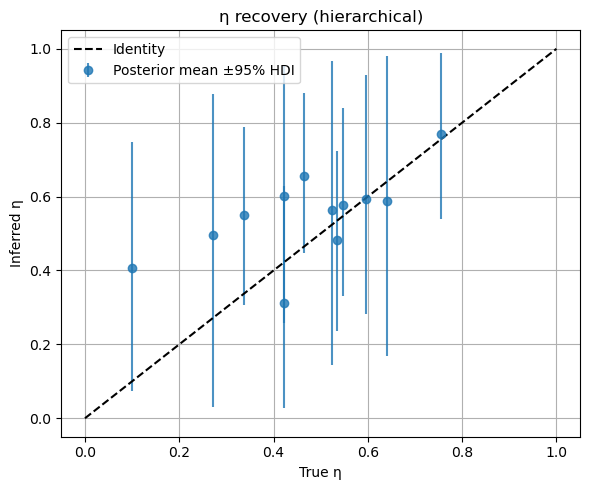

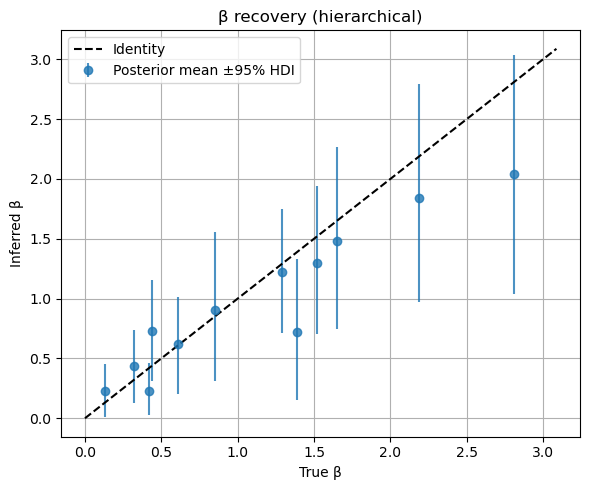

In [69]:
# === 4. Posterior recovery: compare true vs inferred eta and beta ===
# Extract posterior means and 95% HDIs per subject
posterior = trace.posterior  # xarray

# shape: (chain, draw, subject)
eta_post = posterior["eta"].stack(draws=("chain", "draw")).values  # (S, ndraws)
beta_post = posterior["beta"].stack(draws=("chain", "draw")).values

# compute summary stats across draws
eta_mean = eta_post.mean(axis=1)
beta_mean = beta_post.mean(axis=1)
eta_hdi = az.hdi(posterior["eta"], hdi_prob=0.95).sel(hdi=["lower", "higher"])
beta_hdi = az.hdi(posterior["beta"], hdi_prob=0.95).sel(hdi=["lower", "higher"])

subjects = np.arange(n_subjects)

# Merge true and inferred into a DataFrame for plotting
recovery_df = pd.DataFrame({
    "subject": subjects,
    "eta_true": true_params["eta"].values,
    "eta_mean": eta_mean,
    "eta_hdi_lower": eta_hdi["eta"].sel(hdi="lower").values,
    "eta_hdi_upper": eta_hdi["eta"].sel(hdi="higher").values,
    "beta_true": true_params["beta"].values,
    "beta_mean": beta_mean,
    "beta_hdi_lower": beta_hdi["beta"].sel(hdi="lower").values,
    "beta_hdi_upper": beta_hdi["beta"].sel(hdi="higher").values,
})

# === 5. Plot recovery for eta ===
plt.figure(figsize=(6, 5))
plt.errorbar(
    recovery_df["eta_true"],
    recovery_df["eta_mean"],
    yerr=[
        recovery_df["eta_mean"] - recovery_df["eta_hdi_lower"],
        recovery_df["eta_hdi_upper"] - recovery_df["eta_mean"],
    ],
    fmt="o",
    label="Posterior mean ±95% HDI",
    alpha=0.8,
)
plt.plot([0, 1], [0, 1], "k--", label="Identity")
plt.xlabel("True η")
plt.ylabel("Inferred η")
plt.title("η recovery (hierarchical)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Plot recovery for beta ===
plt.figure(figsize=(6, 5))
plt.errorbar(
    recovery_df["beta_true"],
    recovery_df["beta_mean"],
    yerr=[
        recovery_df["beta_mean"] - recovery_df["beta_hdi_lower"],
        recovery_df["beta_hdi_upper"] - recovery_df["beta_mean"],
    ],
    fmt="o",
    label="Posterior mean ±95% HDI",
    alpha=0.8,
)
max_b = max(recovery_df["beta_true"].max(), recovery_df["beta_mean"].max()) * 1.1
plt.plot([0, max_b], [0, max_b], "k--", label="Identity")
plt.xlabel("True β")
plt.ylabel("Inferred β")
plt.title("β recovery (hierarchical)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Fitting real data 